In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import pandas as pd
from pandas.api.types import is_integer_dtype, is_float_dtype

load_dotenv()
os.chdir(os.getenv('BASE_PATH'))


In [2]:
df = pd.read_csv('data/raw/retail_store_inventory.csv')
df.drop(columns=['Date', 'Store ID', 'Product ID'], axis=1, inplace=True)

In [3]:
df = df.rename(columns={'Inventory Level': 'Inventory',
                        'Units Sold': 'Sales',
                        'Units Ordered': 'Orders',
                        'Demand Forecast': 'Demand',
                        'Weather Condition': 'Weather',
                        'Holiday/Promotion': 'Promotion',
                        'Competitor Pricing': 'Competitor Price'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  int64  
 3   Sales             73100 non-null  int64  
 4   Orders            73100 non-null  int64  
 5   Demand            73100 non-null  float64
 6   Price             73100 non-null  float64
 7   Discount          73100 non-null  int64  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  int64  
 10  Competitor Price  73100 non-null  float64
 11  Seasonality       73100 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


In [5]:
def downcast_ints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    int_cols = [c for c in df.columns if is_integer_dtype(df[c])]
    for c in int_cols:
        s = df[c]
        if s.min() >= 0:
            df[c] = pd.to_numeric(s, downcast="unsigned")  # -> uint8/16/32/64
        else:
            df[c] = pd.to_numeric(s, downcast="integer")   # -> int8/16/32/64
    return df

def optimize_df(df: pd.DataFrame) -> pd.DataFrame:
    start = df.memory_usage(deep=True).sum()
    out = df.copy()

    # 1) Downcast integers
    out = downcast_ints(out)

    # 2) Downcast floats
    float_cols = [c for c in out.columns if is_float_dtype(out[c])]
    out[float_cols] = out[float_cols].apply(pd.to_numeric, downcast="float")  # -> float32

    end = out.memory_usage(deep=True).sum()
    print(f"Memory: {start/1024**2:.2f} MB → {end/1024**2:.2f} MB "
          f"({(1 - end/start)*100:.1f}% reduction)")
    return out

df = optimize_df(df)
df.info()


Memory: 22.03 MB → 18.89 MB (14.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  uint16 
 3   Sales             73100 non-null  uint16 
 4   Orders            73100 non-null  uint8  
 5   Demand            73100 non-null  float32
 6   Price             73100 non-null  float32
 7   Discount          73100 non-null  uint8  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  uint8  
 10  Competitor Price  73100 non-null  float32
 11  Seasonality       73100 non-null  object 
dtypes: float32(3), object(4), uint16(2), uint8(3)
memory usage: 3.6+ MB


In [6]:
x = df.drop(columns=['Demand'])
y = df['Demand']

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x['Category'] = label_encoder.fit_transform(x['Category'])
x['Region'] = label_encoder.fit_transform(x['Region'])
x['Weather'] = label_encoder.fit_transform(x['Weather'])
x['Seasonality'] = label_encoder.fit_transform(x['Seasonality'])
x['Promotion'] = label_encoder.fit_transform(x['Promotion'])

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [10]:
class HParamMetrics:

  def __init__(self, est):
    self.est = est
    self.train_rn = None
    self.y_pred = None
    self.test_r2 = None
    self.mse = None
    self.rmse = None
    self.mae = None

In [11]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, x_train, y_train, x_test, y_test, HPM):
  # calculate metrics
  HPM.train_r2 = model.score(x_train, y_train)
  HPM.y_pred = model.predict(x_test)
  HPM.test_r2 = r2_score(y_test, HPM.y_pred)
  HPM.mse = mean_squared_error(y_test, HPM.y_pred)
  HPM.rmse = np.sqrt(HPM.mse)
  HPM.mae = mean_absolute_error(y_test, HPM.y_pred)

  #prepare the table data
  metrics = [
    ["Training R^2 Score", f"{HPM.train_r2:.4f}"],
    ["Testing R^2 Score", f"{HPM.test_r2:.4f}"],
    ["Mean Squared Error (MSE)", f"{HPM.mse:.2f}"],
    ["Root Mean Squared Error (RMSE)", f"{HPM.rmse:.2f}"],
    ["Mean Absolute Error (MAE)", f"{HPM.mae:.2f}"],
  ]

  # Print the table
  print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

initial_HPM = HParamMetrics(lr.fit(x_train, y_train))

In [13]:
evaluate_model(lr, x_train, y_train, x_test, y_test, initial_HPM)

+--------------------------------+---------+
| Metric                         |   Value |
+================================+=========+
| Training R^2 Score             |  0.9937 |
+--------------------------------+---------+
| Testing R^2 Score              |  0.9937 |
+--------------------------------+---------+
| Mean Squared Error (MSE)       | 73.99   |
+--------------------------------+---------+
| Root Mean Squared Error (RMSE) |  8.6    |
+--------------------------------+---------+
| Mean Absolute Error (MAE)      |  7.44   |
+--------------------------------+---------+


In [14]:
print(initial_HPM.est)

LinearRegression()


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
               'positive': [True,False]}


rs = RandomizedSearchCV(
	initial_HPM.est,
	param_distributions=param_dist,
	verbose=1,
  cv=10,
)

rs.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,LinearRegression()
,param_distributions,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'n_jobs': [1, 5, ...], 'positive': [True, False]}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [16]:
rs.cv_results_

{'mean_fit_time': array([0.01863978, 0.02960682, 0.01975536, 0.01445904, 0.01488633,
        0.02126033, 0.01396084, 0.01356986, 0.03166676, 0.02734528]),
 'std_fit_time': array([0.00255522, 0.01540535, 0.00494564, 0.0013193 , 0.00087185,
        0.00510672, 0.00074259, 0.00119762, 0.0037437 , 0.00322991]),
 'mean_score_time': array([0.00134833, 0.00166235, 0.00186734, 0.00154133, 0.00169866,
        0.00200164, 0.00159187, 0.00183995, 0.00164468, 0.0015353 ]),
 'std_score_time': array([0.00028885, 0.00031768, 0.00043168, 0.00055859, 0.00041569,
        0.00069643, 0.00046889, 0.00056418, 0.00028261, 0.00039729]),
 'param_positive': masked_array(data=[False, True, True, False, False, True, False, False,
                    True, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=True),
 'param_n_jobs': masked_array(data=[1, 5, None, 1, 15, 10, 10, 10, 1, None],
              mask=[False, False, False,

In [17]:
df.columns

Index(['Category', 'Region', 'Inventory', 'Sales', 'Orders', 'Demand', 'Price',
       'Discount', 'Weather', 'Promotion', 'Competitor Price', 'Seasonality'],
      dtype='object')

In [18]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
pca = PCA(n_components=2)
_, x_pre_pca, _, y_pca = train_test_split(x, y, test_size=0.2)
X_pca = pca.fit_transform(x_pre_pca)


In [27]:
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.18012497 0.14449175]
Cumulative: [0.18012497 0.32461671]


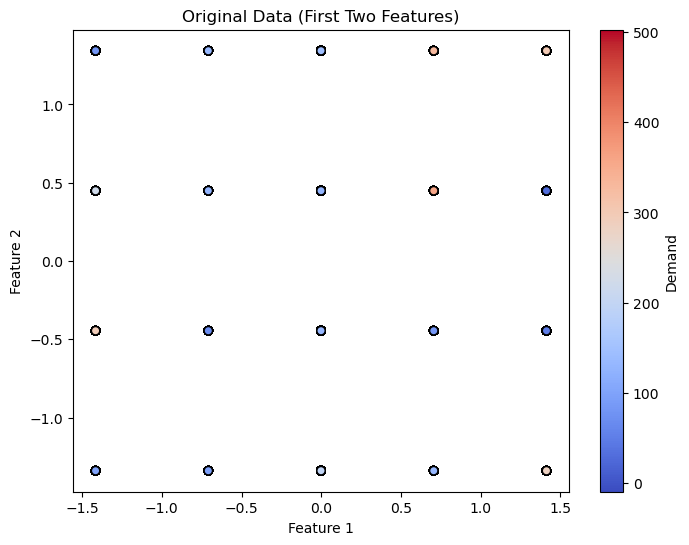

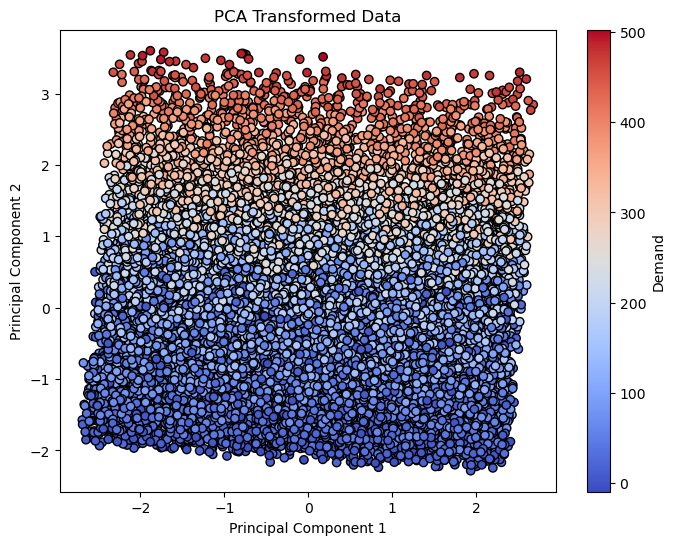

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(x_pre_pca[:, 0], x_pre_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Original Data (First Two Features)")
plt.colorbar(label="Demand")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Transformed Data")
plt.colorbar(label="Demand")
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.2)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [ ]:
def create_pie(y_pred, y_test, margin):
  scores = [1 if abs(pred - test) <= margin else 0 for pred, test in zip(y_pred, y_test)]

  scores_tuple = (scores.count(0), scores.count(1))
  plt.figure(figsize=(8,6))
  plt.pie(scores_tuple, labels=('0', '1'))
  plt.title(f"Predictions within {margin} of actual demand")
  plt.legend(labels=[f'Not within {margin}: {scores_tuple[0]}', f'Within {margin}: {scores_tuple[1]}'])
  
  plt.show()

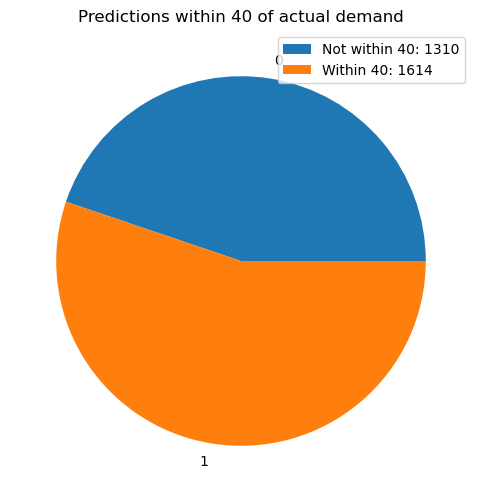

In [74]:
create_pie(y_pred, y_test, 40)

In [34]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ValueError: continuous is not supported